<a href="https://colab.research.google.com/github/pyt3r/springboard-package/blob/master/capstone/Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Colab Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pathlib
root = pathlib.Path('/content/drive/MyDrive/home/Research/Springboard/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read OHLC Data

In [3]:
ohlc = pd.read_csv( root / 'ohlc.csv' )
ohlc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,9/10/2025,111539.06,113745.24,110959.16,113538.72,113538.72,5.259328e+10
1,9/9/2025,112077.58,113225.44,110776.70,111530.55,111530.55,4.598448e+10
2,9/8/2025,111163.02,112869.23,110630.61,112071.43,112071.43,4.021281e+10
3,9/7/2025,110221.33,111591.08,110211.63,111167.62,111167.62,2.461801e+10
4,9/6/2025,110650.57,111275.02,110024.09,110224.70,110224.70,2.150072e+10


In [4]:
ohlc.shape

(366, 7)

- Date Range

In [5]:
ohlc['Date'] = pd.to_datetime( ohlc['Date'] )
ohlc.Date.min(), ohlc.Date.max()

(Timestamp('2024-09-10 00:00:00'), Timestamp('2025-09-10 00:00:00'))

- Closing Prices

In [6]:
ohlc.Close.min(), ohlc.Close.max()

(57343.17, 123344.06)

- Sort by date

In [7]:
ohlc = ohlc.sort_values( 'Date', ascending=True )
ohlc.set_index( 'Date', inplace=True )
ohlc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-09-10,57020.10,58029.98,56419.41,57648.71,57648.71,2.885763e+10
2024-09-11,57650.29,57991.32,55567.34,57343.17,57343.17,3.704906e+10
2024-09-12,57343.17,58534.36,57330.10,58127.01,58127.01,3.383571e+10
2024-09-13,58130.32,60648.02,57650.11,60571.30,60571.30,3.249053e+10
2024-09-14,60569.12,60656.72,59517.88,60005.12,60005.12,1.642841e+10


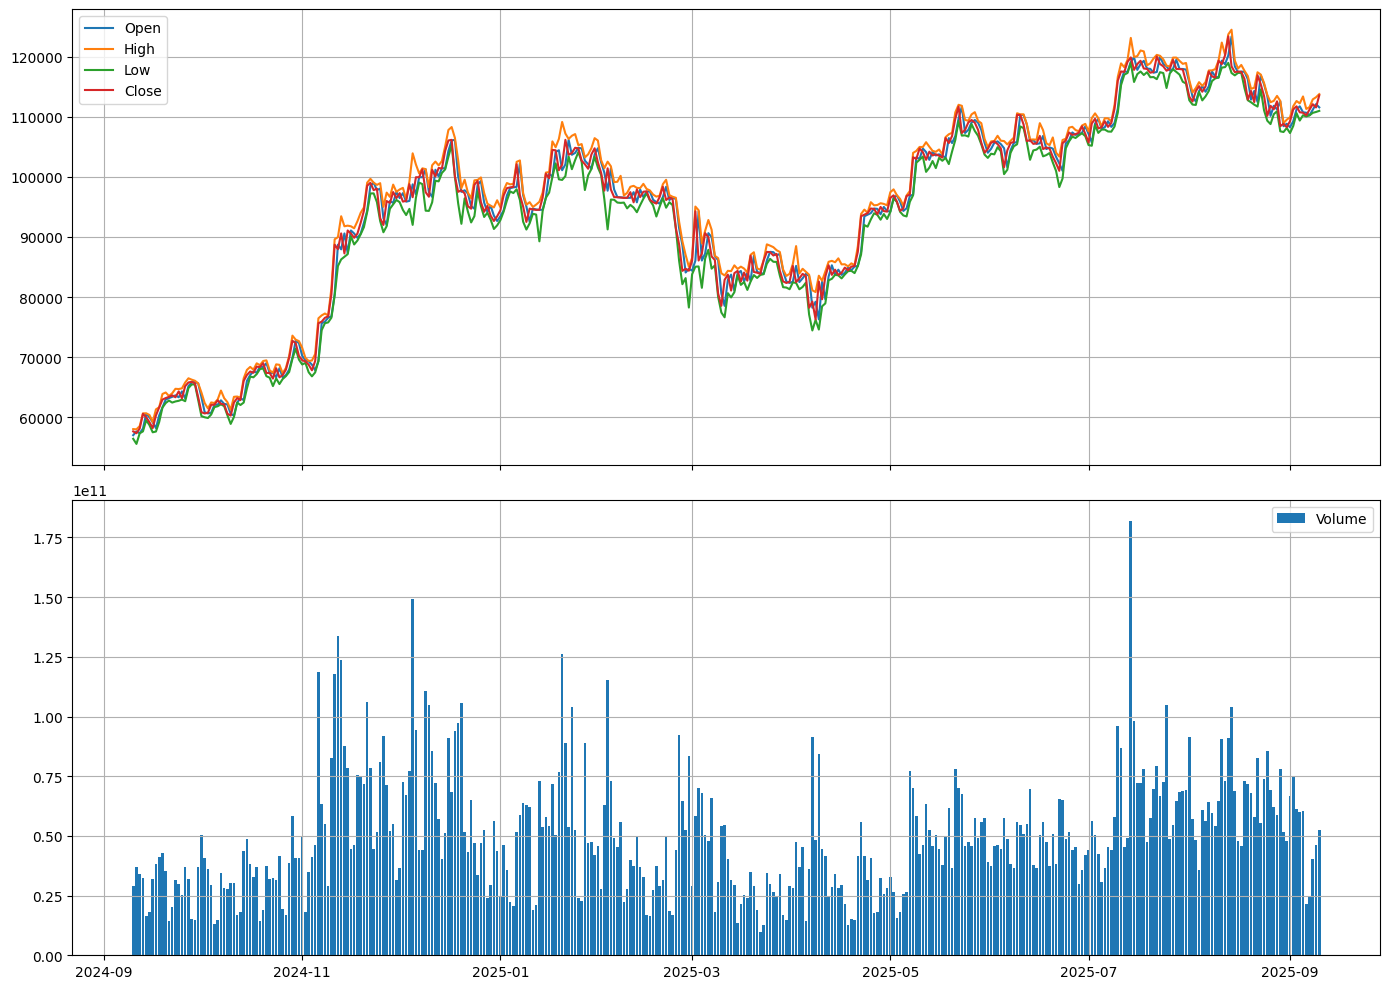

In [8]:
DF = ohlc

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

top = ['Open', 'High', 'Low', 'Close']
bottom = ['Volume']

for c in top:
  ax1.plot(DF.index, DF[c], label=c)

for c in bottom:
  ax2.bar(DF.index, DF[c], label=c)

for ax in [ax1, ax2]:
  ax.legend()
  ax.grid(True)

plt.tight_layout()
plt.show()

## Moving Averages

In [9]:
def simpleMA( metric, window ):
  return metric.rolling( window ).mean()

def expMA( metric, window ):
  return metric.ewm( span=window, min_periods=window ).mean()

In [10]:
price = ohlc['Close']

window = 30

MA = pd.DataFrame({
    f'sma({window})': simpleMA(price, window),
    f'ema({window})': expMA(price, window), })


## Crossover

In [11]:
def crossover( s1, s2, lag ):
  x = s1 - s2
  x = x * 0 + np.sign(x)
  return x.shift(lag)

In [12]:
price = ohlc['Close']

short_window = 15
long_window =  50
lag = 1

short = simpleMA(price, short_window)
long  = simpleMA(price, long_window)
cross = crossover(short, long, lag)

Crossover = pd.DataFrame({
    f'x(sma({short_window}),sma({long_window}))': cross, })


## Bollinger Bands

In [13]:
def bollUpper( metric, window, stdevs ):
    return boll( metric, window, abs( stdevs ))

def bollLower( metric, window, stdevs ):
    return boll( metric, window, -abs( stdevs ))

def boll( metric, window, stdevs ):
    ma = simpleMA( metric, window )
    std = stDev( metric, window )
    return ma + ( std * stdevs )

def stDev( metric, window ):
    return metric.rolling( window ).std()


In [14]:
price = ohlc['Close']

window = 20
stdevs = 2

results = [
    bollUpper(price, window, stdevs),
    bollLower(price, window, stdevs), ]

names = [
    f'bollUpper({window},{stdevs})',
    f'bollLower({window},{stdevs})', ]

Bollinger = pd.DataFrame(dict(zip(names, results)))


### Moving Average Convergence Divergence (MACD)

Moving Average Convergence Divergence (MACD) involves the following three calculations; the last of which, the MACD distance, may be used by analysts in determining the magnitude of bullish or bearish momentum.

1. MACD is the difference between a long and short EMA.

2. The Signal Line is then the EMA of the MACD (#1).

3. The MACD Distance is the difference between the MACD (#1) and Signal Line (#2).

In [15]:
def macd(metric, short_window, long_window):
    short = expMA( metric, short_window )
    long = expMA( metric, long_window )
    return short - long


def macdDistance(macd_metric, signal_metric):
    return macd_metric - signal_metric

In [16]:
price = ohlc['Close']

short_window = 12
long_window = 26
signal_window = 9

short       = expMA( price, short_window )
long        = expMA( price, long_window )
macd_metric = macd( price, short_window, long_window )
signal      = expMA( macd_metric, signal_window )
dist        = macdDistance( macd_metric, signal )

Macd = pd.DataFrame({
  f'macdDistance({short_window}, {long_window}, {signal_window})': dist,
})



## Oscillators

An oscillator is a trend indicator that fluctuates between an upper and a lower bound. Like Bollinger Bands, analysts use oscillators to help identify oversold and overbought signals.

Generally, an analyst might use a threshold above 70% or 80% to indicate an overbought asset, and a threshold below 30% or 20% to indicate an underbought asset.

### Relative Strength Index (RSI)

In [17]:
def rsiBase(metric, window, funcMA):
    diff = metric.diff()
    signs = np.sign(diff)
    isPositive = (signs + 1) / 2
    isNegative = (signs - 1).abs() / 2

    gain = isPositive * diff
    loss = isNegative * diff.abs()

    avgGain = funcMA(gain, window)
    avgLoss = funcMA(loss, window)

    rsi = avgGain / avgLoss
    rsi = 100 / (1 + rsi)
    return 100 - rsi


def rsiSma(metric, window):
    return rsiBase(metric, window, funcMA=simpleMA)


def rsiEma(metric, window):
    return rsiBase(metric, window, funcMA=expMA)

In [18]:
price = ohlc['Close']

window = 14

Rsi = pd.DataFrame({
    f'rsiSma({window})' : rsiSma(price, window),
    f'rsiEma({window})' : rsiEma(price, window), })


### Money Flow Index (MFI)

Tracks price movement, weighted by how much money is behind the movement.

For example:
- As prices rise with increasing volume, MFI might confirm that there's genuine buying pressure.
- But if prices are rising while the MFI fails to follow suit, that can be a warning that the rally is on shaky ground

In [19]:
def mfi(high, low, close, volume, window):
    tmp = mfiRatio(high, low, close, volume, window)
    tmp += 1
    return 100 - (100 / tmp)


def mfiRatio(high, low, close, volume, window):
    price = typicalPrice(high, low, close)
    mf = rawMoneyFlow(high, low, close, volume)

    diff = price.diff()
    signs = np.sign(diff)
    isPositive = (signs + 1) / 2
    isNegative = (signs - 1).abs() / 2

    mf_positive = mf * isPositive
    mf_negative = mf * isNegative

    ratio = mf_positive.rolling(window).sum()
    ratio /= mf_negative.rolling(window).sum()
    return ratio


def rawMoneyFlow(high, low, close, volume):
    return typicalPrice(high, low, close) * volume


def typicalPrice(high, low, close):
    return (high + low + close) / 3

In [20]:
window = 14

high   = ohlc['High']
low    = ohlc['Low']
close  = ohlc['Close']
volume = ohlc['Volume']

Mfi = pd.DataFrame({
    f'mfi({window})' : mfi(high, low, close, volume, window), })


## Features


In [21]:
Features = pd.concat([
    MA,
    Crossover,
    Bollinger,
    Macd,
    Rsi,
    Mfi,
], axis=1 )

print(len(Features))
Features.tail()


366


,sma(30),ema(30),"x(sma(15),sma(50))","bollUpper(20,2)","bollLower(20,2)","macdDistance(12, 26, 9)",rsiSma(14),rsiEma(14),mfi(14)
Date,,,,,,,,,
2025-09-06,114061.796,112719.860474,-1.0,116790.061701,106850.665299,31.246031,36.390459,43.325287,49.517919
2025-09-07,113877.759,112619.715928,-1.0,116080.579405,107051.678595,123.447427,43.617566,49.689109,55.602814
2025-09-08,113730.128,112584.342642,-1.0,116010.442618,107045.840382,245.823697,56.274451,55.246898,64.088129
2025-09-09,113470.921,112516.356020,-1.0,115683.202514,107098.661486,287.940804,49.053761,51.331334,66.056176
2025-09-10,113297.830,112582.314986,-1.0,115824.018564,107069.814436,439.563315,57.328382,62.666593,65.646769


In [22]:
Features = Features.dropna()
print(len(Features))


316


## Target

In [23]:
price  = ohlc['Close']

shiftby  = -1
Target = ( price.diff().shift(shiftby) > 0 ).astype( int )
Target = Target.iloc[ :shiftby ] if shiftby < 0 else Target.iloc[ shiftby: ]

index = Target.index.intersection( Features.index )



## Train

In [24]:
Features = Features.loc[ index ]
Target   = Target.loc[ index ].squeeze()

print( len(Features), len(Target) )
print( Features.isnull().sum().sum(), Target.isnull().sum() )

Target.value_counts()


315 315
0 0


,count
Close,
1,160
0,155


In [25]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


def crossValidationForLogisticRegression( features, target, n_splits=5, random_state=42 ):

    metrics = []
    importances = []


    X = features.values
    y = target.values
    tscv = TimeSeriesSplit( n_splits=n_splits )
    for trainIdx, testIdx in tscv.split(X):

        pipeline = Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("logistic", LogisticRegression(
                solver       = 'liblinear',
                max_iter     = 2000,
                random_state = random_state
            ))
        ])
        pipeline.fit(X[trainIdx], y[trainIdx])

        y_pred  = pipeline.predict(X[testIdx])
        y_proba = pipeline.predict_proba(X[testIdx])[:, 1]

        metrics.append({
            'roc_auc'  : roc_auc_score( y[testIdx], y_proba ),
            'accuracy' : accuracy_score( y[testIdx], y_pred ),
            'f1'       : f1_score( y[testIdx], y_pred ),
        })


        lr = pipeline.named_steps["logistic"]
        importances.append( dict( zip( Features.columns, lr.coef_[0], )))

    return pd.DataFrame( metrics ), pd.DataFrame( importances ).T


metrics, importances = crossValidationForLogisticRegression( Features, Target, n_splits=5 )

print( metrics.mean() )

importances.mean(1).abs().sort_values( ascending=False )



roc_auc     0.546083
accuracy    0.503846
f1          0.326203
dtype: float64


,0
rsiSma(14),0.583134
"macdDistance(12, 26, 9)",0.525296
"bollLower(20,2)",0.373629
ema(30),0.282009
sma(30),0.222065
"x(sma(15),sma(50))",0.180008
rsiEma(14),0.168882
"bollUpper(20,2)",0.149608
mfi(14),0.072163
